## Working on the adjacency matrices first

#### Discriminating by year first

In [1]:
import numpy as np 
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import os
import sys

# add parent directory to path so we can import from util
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# import module from util
from util.merge_fams import merge_fams

df = merge_fams("../data/CosciaRios2012_DataBase.csv")
# os.makedirs('../data/cartel_adj_mat', exist_ok=True)

family_cols = df.columns[3:]
matrices = {}

for year in range(df['Year'].min(), df['Year'].max() + 1):
    df_year = df[df['Year'] == year].set_index('Code')[family_cols].astype(int)
    adj_weighted = df_year.T @ df_year
    np.fill_diagonal(adj_weighted.values, 0)
    matrices[year] = adj_weighted
    
    # with open(f'../data/cartel_adj_mat/{year}.csv', 'w') as f:
    #     adj_weighted.to_csv(f)

matrices

{1990:                Beltran_Leyva  Familia  Golfo  Juarez  Sinaloa  Tijuana  Zetas  \
 Beltran_Leyva              0        0      0       0        0        0      0   
 Familia                    0        0      0       0        0        0      0   
 Golfo                      0        0      0       0        0        0      0   
 Juarez                     0        0      0       0        0        0      0   
 Sinaloa                    0        0      0       0        0        0      0   
 Tijuana                    0        0      0       0        0        0      0   
 Zetas                      0        0      0       0        0        0      0   
 Otros                      0        0      0       0        0        0      0   
 
                Otros  
 Beltran_Leyva      0  
 Familia            0  
 Golfo              0  
 Juarez             0  
 Sinaloa            0  
 Tijuana            0  
 Zetas              0  
 Otros              0  ,
 1991:                Beltran_Leyva  

#### Non-zero adjacency matrices

In [3]:
nonzero_years = [year for year, mat in matrices.items() if np.any(mat != 0)]
print("Years with non-zero adjacency entries:", nonzero_years)

Years with non-zero adjacency entries: [1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010]


This means that years 1990 and 1991 do not have the ability to create edges between families as there is no family presence in any municipality, or there is no **shared** presence that creates an edge 

#### Maximum weight (number of municipalities shared by two families) in all years

In [4]:
max_weight = np.array(list(matrices.values())).max() # will use this value to plot thick edges later
max_weight

189

#### Across all years combined

In [8]:
# number of appearances per family in each municipality across all 20 years
df_collapsed = df.groupby('Code')[family_cols].sum() #muni codes are already indeces 
df_collapsed = (df_collapsed > 0).astype(int)

# project on families
adj_all_years = df_collapsed.T @ df_collapsed
np.fill_diagonal(adj_all_years.values, 0)

adj_all_years # weights: number of distinct municipalities where each pair of families have co-appeared, not necessarily in the same year

,Beltran_Leyva,Familia,Golfo,Juarez,Sinaloa,Tijuana,Zetas,Otros
Beltran_Leyva,0,138,200,92,189,83,230,61
Familia,138,0,188,66,137,59,221,55
Golfo,200,188,0,108,210,93,381,68
Juarez,92,66,108,0,133,74,103,53
Sinaloa,189,137,210,133,0,100,225,70
Tijuana,83,59,93,74,100,0,84,47
Zetas,230,221,381,103,225,84,0,64
Otros,61,55,68,53,70,47,64,0


In [9]:
adj_all_years.equals(adj_all_years.T)  # Check for symmetry

True

---

## Projection on family cartels
Discriminating by year

In [6]:
import numpy as np 
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

df = merge_fams("../data/CosciaRios2012_DataBase.csv")

family_cols = df.columns[3:]
graphs_by_year = {} #key: year, value: networkx graph
edge_data = {}

for year in range(df['Year'].min(), df['Year'].max() + 1):
    df_year = df[df['Year'] == year].set_index('Code')[family_cols].astype(int)
    adj_weighted = df_year.T @ df_year
    np.fill_diagonal(adj_weighted.values, 0)

    A = adj_weighted.values  #numpy
    labels = adj_weighted.index.to_numpy()  # family labels
    
    # indices of upper triangle, excluding diagonal
    rows, cols = np.triu_indices(A.shape[0], k=1) #pairs of indices

    # weights at those positions
    weights = A[rows, cols]

    # keep only existing edges
    mask = weights > 0

    edge_list = np.column_stack((
        labels[rows[mask]],
        labels[cols[mask]],
        weights[mask]
    ))

    G_year = nx.Graph()
    G_year.add_nodes_from(family_cols)
    G_year.add_weighted_edges_from(edge_list)
    graphs_by_year[year] = G_year

# example 1
graphs_by_year[2005].nodes()


NodeView(('Beltran_Leyva', 'Familia', 'Golfo', 'Juarez', 'Sinaloa', 'Tijuana', 'Zetas', 'Otros'))

#### Plotting an example from the graphs_by_year dict

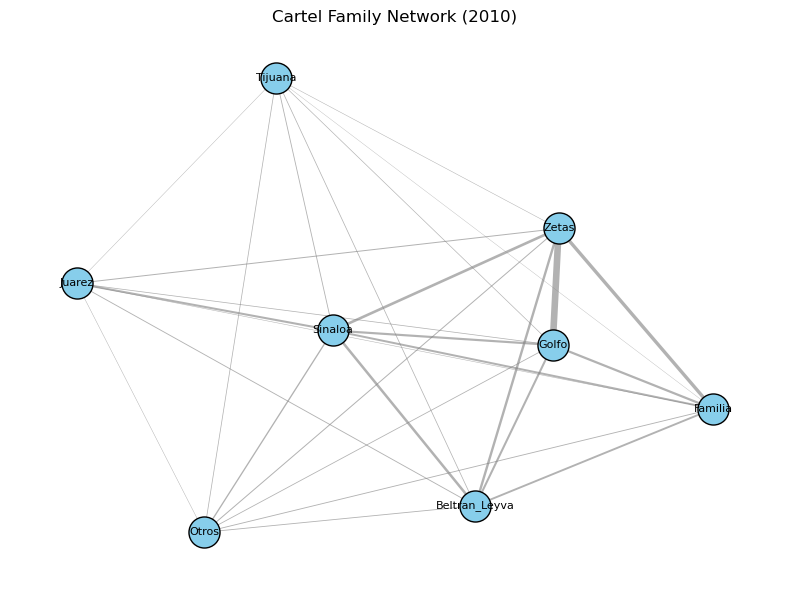

In [19]:
# example 2
G_example = graphs_by_year[2010]
plt.figure(figsize=(8,6))
pos = nx.spring_layout(G_example, weight='weight', seed=42) #nodes with higher weights are closer together

example_edges = G_example.edges()
example_weights = np.array([G_example[u][v]['weight'] for u,v in example_edges])
example_weights = example_weights / max_weight * 5  # normalize for plotting

nx.draw_networkx_edges(G_example, pos, width=example_weights, edge_color="gray", alpha=0.6)
nx.draw_networkx_nodes(G_example, pos, node_color="skyblue", node_size=500, edgecolors="black")
nx.draw_networkx_labels(G_example, pos, font_size=8, font_color="black")

plt.title("Cartel Family Network (2010)")
plt.axis('off')
plt.tight_layout()
plt.show()

Aggregate graph over all 20 years (weight represents number of distinct municipalities two families have had in common)

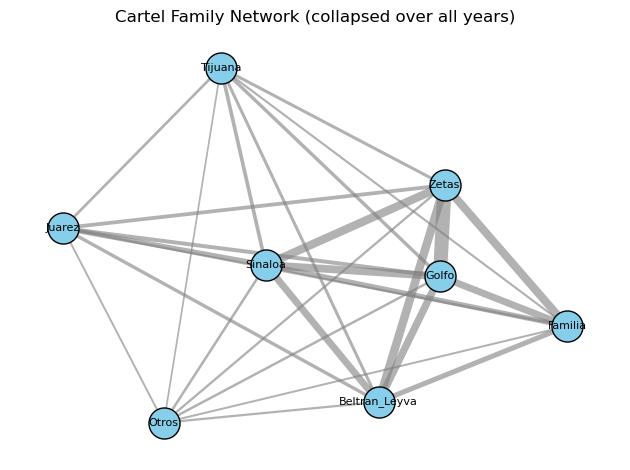

In [20]:
G_collapsed = nx.Graph()
G_collapsed.add_nodes_from(family_cols)
G_collapsed = nx.from_pandas_adjacency(adj_all_years)

collapsed_edges = G_collapsed.edges()
collapsed_weights = np.array(list(G_collapsed.edges(data='weight')))[:,2].astype(int)
collapsed_weights = collapsed_weights / max_weight * 5  # normalize for plotting

nx.draw_networkx_edges(G_collapsed, pos, width=collapsed_weights, edge_color="gray", alpha=0.6)
nx.draw_networkx_nodes(G_collapsed, pos, node_color="skyblue", node_size=500, edgecolors="black")
nx.draw_networkx_labels(G_collapsed, pos, font_size=8, font_color="black")

plt.title("Cartel Family Network (collapsed over all years)")
plt.axis('off')
plt.tight_layout()
plt.show()

The difference in weights from 2010 is clear, suggesting each year adds connections between families through different municipalities:

- If families always appeared in the same municipalities year after year, then 2010 (latest year) would capture most of the cumulative pattern
- Since 2010 is much sparser than the collapsed network, it means families co-occur in different sets of municipalities across different years
- This reveals temporal variation in geographic operations rather than static territorial control


#### Observing network evolution for the last 9 years (static)

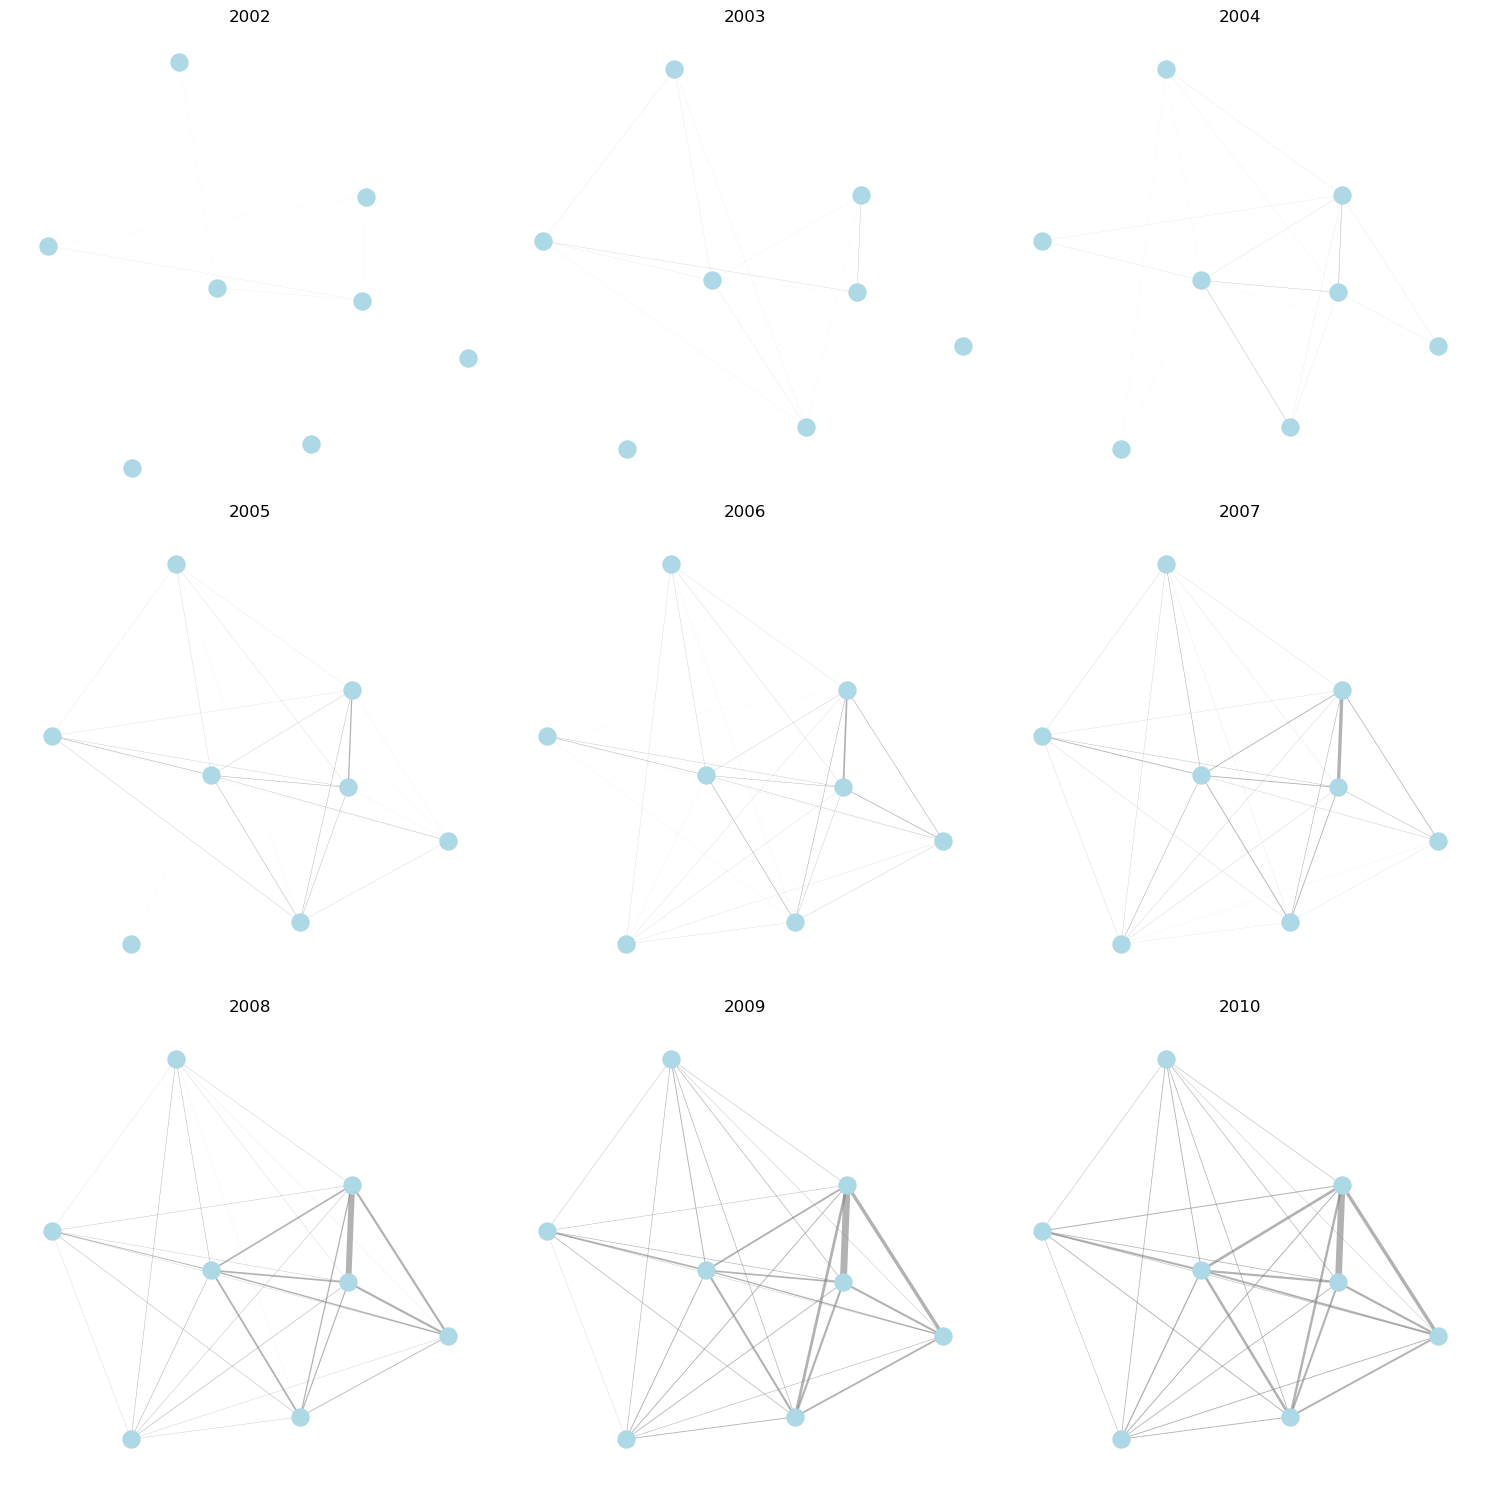

In [21]:
import matplotlib.pyplot as plt
import networkx as nx

# Select years to visualize
years_to_plot = list(range(2002, 2011))  # 2004–2010 inclusive

# defining layout once (so positions are consistent across years)
reference_year = years_to_plot[-1]
pos = nx.spring_layout(graphs_by_year[reference_year], weight='weight', seed=42) 

# Create figure with one row and N columns
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for i, year in enumerate(years_to_plot):
    ax = axes[i]
    G = graphs_by_year[year]
    year_edges = G.edges()
    year_weights = np.array([G[u][v]['weight'] for u,v in year_edges])
    year_weights = year_weights / max_weight * 5  # normalize for plotting
    
    # Reuse same node positions but adjust for missing nodes
    nx.draw_networkx_edges(G, pos, width=year_weights, edge_color="gray", alpha=0.6, ax=ax)
    nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=150, ax=ax)

    ax.set_title(str(year))
    ax.axis("off")

plt.tight_layout()
plt.show()

We observe edges get thicker and thicker over the years, but as we observed in the previous plot, those connections are not caused by the same co-ocurrence in the same municipalities.

#### Observing network evolution over all 20 years (animated plot)

In [54]:
import networkx as nx
import matplotlib.pyplot as plt
import imageio
import os

# Select years to visualize
years_to_plot = list(range(min(graphs_by_year.keys()), max(graphs_by_year.keys()) + 1)) 

# defining layout once (so positions are consistent across years) - used 2010 network as reference as it's the most dense of them all 
pos = nx.spring_layout(graphs_by_year[2010], weight='weight', seed=42) 

frames = []
temp_dir = "network_frames_fixed_temp"
os.makedirs(temp_dir, exist_ok=True)

for idx, year in enumerate(years_to_plot):
    G = graphs_by_year[year]
    year_edges = G.edges()
    year_weights = np.array([G[u][v]['weight'] for u,v in year_edges])
    year_weights = year_weights / max_weight * 5  # normalize for plotting
    
    # Reuse same node positions but adjust for missing nodes
    nx.draw_networkx_edges(G, pos, width=year_weights, edge_color="gray", alpha=0.6)
    nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=500)
    nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")

    plt.title(f"Original Projected Network on Families - Year: {year}", fontsize=14)
    plt.axis('off')
    plt.tight_layout()

    # save year plots in a temporary directory
    fname = os.path.join(temp_dir, f"frame_{idx:02d}.png")
    plt.savefig(fname)
    plt.close()
    frames.append(imageio.imread(fname))

# turn all the images in the directory to a gif
imageio.mimsave('../PRESENTATION/network_evolution.gif', frames, fps=2)

# delete images from temporary directory
import shutil
shutil.rmtree(temp_dir)

print("Animation saved as 'network_evolution.gif'")

C:\Users\Maribel ITU\AppData\Local\Temp\ipykernel_22112\114579425.py:35: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(fname))


Animation saved as 'network_evolution.gif'


---
## Network properties over time

#### Number of nodes
Safe check

In [23]:
import pandas as pd

# Check number of nodes for each year
nodes_by_year = []
for year in sorted(graphs_by_year.keys()):
    G = graphs_by_year[year]
    n_nodes = G.number_of_nodes()
    nodes_by_year.append({'Year': year, 'Nodes': n_nodes})

nodes_df = pd.DataFrame(nodes_by_year)

print("NUMBER OF NODES (FAMILIES) PER YEAR")
print(nodes_df.to_string(index=False))
print(f"All years have {nodes_df['Nodes'].unique()[0]} nodes: {nodes_df['Nodes'].nunique() == 1}")


NUMBER OF NODES (FAMILIES) PER YEAR
 Year  Nodes
 1990      8
 1991      8
 1992      8
 1993      8
 1994      8
 1995      8
 1996      8
 1997      8
 1998      8
 1999      8
 2000      8
 2001      8
 2002      8
 2003      8
 2004      8
 2005      8
 2006      8
 2007      8
 2008      8
 2009      8
 2010      8
All years have 8 nodes: True


#### Number of edges per year 

REPORTED CASES BY YEAR
 Year  Edges
 1990      0
 1991      0
 1992      1
 1993      2
 1994      2
 1995      2
 1996      4
 1997      1
 1998      4
 1999      2
 2000      4
 2001     11
 2002      5
 2003     13
 2004     19
 2005     22
 2006     26
 2007     27
 2008     28
 2009     28
 2010     28


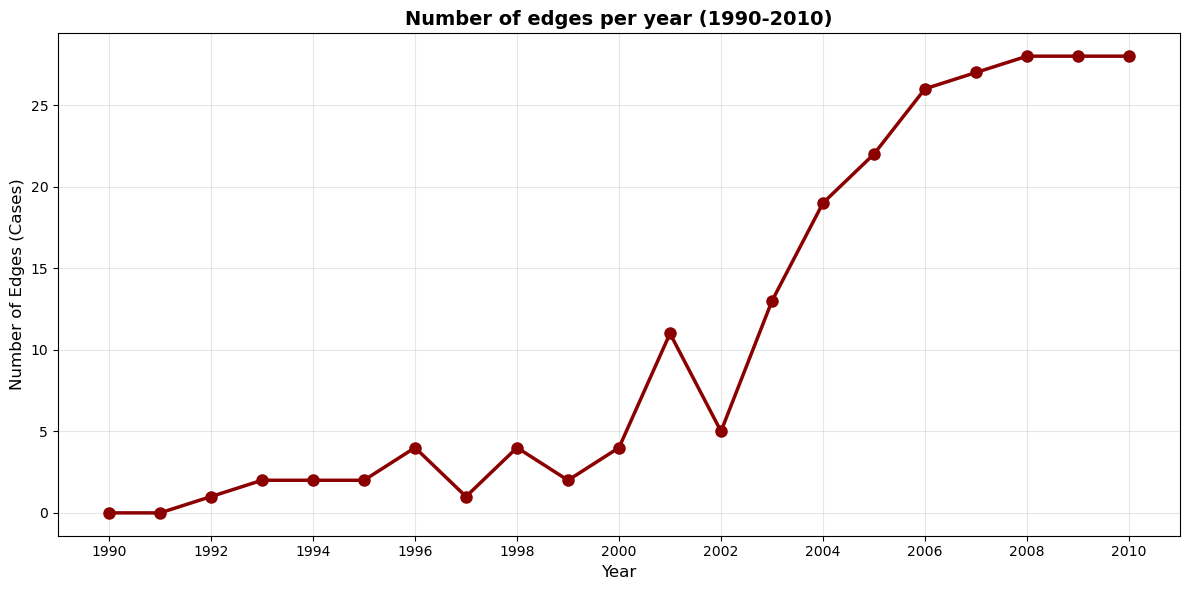

In [24]:
metrics_data = []

for year in sorted(graphs_by_year.keys()):
    G = graphs_by_year[year]
    n_edges = G.number_of_edges()
    
    metrics_data.append({
        'Year': year,
        'Edges': n_edges
    })

metrics_df = pd.DataFrame(metrics_data)

# Print the number of edges per year
print("REPORTED CASES BY YEAR")
print(metrics_df.to_string(index=False))

# Plot: Number of Edges over time
plt.figure(figsize=(12, 6))
plt.plot(metrics_df['Year'], metrics_df['Edges'], marker='o', linewidth=2.5, markersize=8, color='darkred')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Edges (Cases)', fontsize=12)
plt.title('Number of edges per year (1990-2010)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(range(1990, 2011, 2))
plt.tight_layout()
plt.savefig('../presentation/number_of_edges_per_year.png', dpi=300, bbox_inches='tight')
plt.show()

#### Average degree

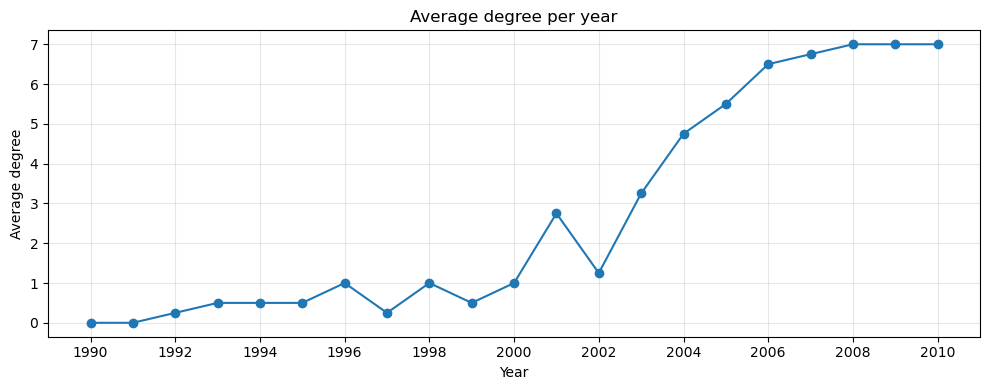

In [25]:
# Simple: compute and plot average (unweighted) degree per year
import pandas as pd
import matplotlib.pyplot as plt

avg_rows = []

for year in sorted(graphs_by_year.keys()):
    G = graphs_by_year[year]
    n = G.number_of_nodes()
    if n > 0:
        avg_deg = sum(dict(G.degree()).values()) / n
    else:
        avg_deg = 0
    avg_rows.append({'Year': year, 'AverageDegree': round(avg_deg, 2)})

avg_df = pd.DataFrame(avg_rows)

plt.figure(figsize=(10,4))
plt.plot(avg_df['Year'], avg_df['AverageDegree'], marker='o', color='tab:blue')
plt.xlabel('Year')
plt.ylabel('Average degree')
plt.title('Average degree per year')
plt.grid(alpha=0.3)
plt.xticks(range(min(avg_df['Year']), max(avg_df['Year'])+1, 2))
plt.tight_layout()
plt.savefig('../presentation/average_degree_per_year.png', dpi=300, bbox_inches='tight')
plt.show()

Doesn’t change much from our number of edges since its just the number of edges divided per 10

#### Degree per family through the years

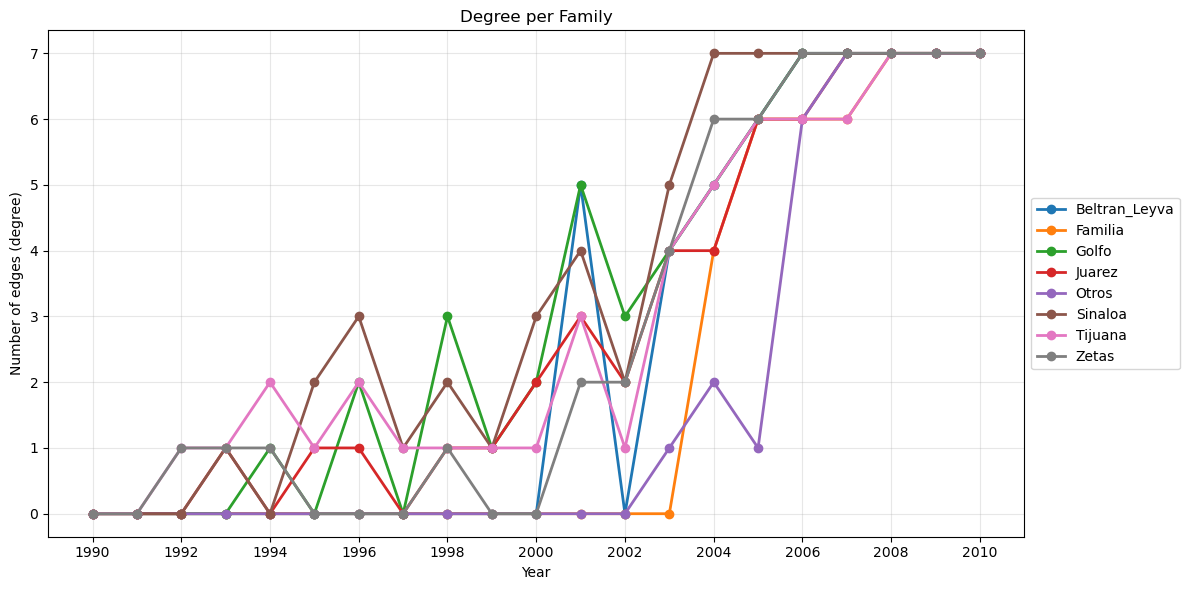

In [26]:
rows = []
for year in sorted(graphs_by_year.keys()):
    G = graphs_by_year[year]
    deg = dict(G.degree())
    # family nodes are strings; municipality nodes are numeric codes
    fam_nodes = sorted([n for n in G.nodes() if isinstance(n, str)])
    for fam in fam_nodes:
        rows.append({'Year': year, 'Family': fam, 'Degree': deg.get(fam, 0)})
df_deg = pd.DataFrame(rows)

pivot_deg = df_deg.pivot(index='Year', columns='Family', values='Degree').fillna(0)

# Plot: one line per family
plt.figure(figsize=(12, 6))
for fam in pivot_deg.columns:
    plt.plot(pivot_deg.index, pivot_deg[fam], marker='o', label=fam, linewidth=2)

plt.xlabel('Year')
plt.ylabel('Number of edges (degree)')
plt.title('Degree per Family')
plt.grid(alpha=0.3)
plt.xticks(range(1990, 2011, 2))

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()

plt.savefig('../presentation/degree_per_family.png', dpi=300, bbox_inches='tight')

plt.show()

#### Density and Diameter

In [27]:
results = []

for year in sorted(graphs_by_year.keys()):
    G = graphs_by_year[year]

    if nx.is_connected(G):
        diameter = nx.diameter(G)
    else:
        components = list(nx.connected_components(G))
        if not components:
            diameter = float('nan')
        
        largest_cc = G.subgraph(max(components, key=len))
        
        if largest_cc.number_of_nodes() > 1:
            diameter = nx.diameter(largest_cc)
        else:
            diameter = float('nan')
    
    results.append({
        'year': year,
        'num_edges': G.number_of_edges(),
        'density': nx.density(G),
        'diameter':  diameter
    })

results_df = pd.DataFrame(results)
results_df

,year,num_edges,density,diameter
0,1990,0,0.000000,NaN
1,1991,0,0.000000,NaN
2,1992,1,0.035714,1.0
3,1993,2,0.071429,1.0
4,1994,2,0.071429,2.0
5,1995,2,0.071429,2.0
6,1996,4,0.142857,2.0
7,1997,1,0.035714,1.0
8,1998,4,0.142857,3.0
9,1999,2,0.071429,1.0


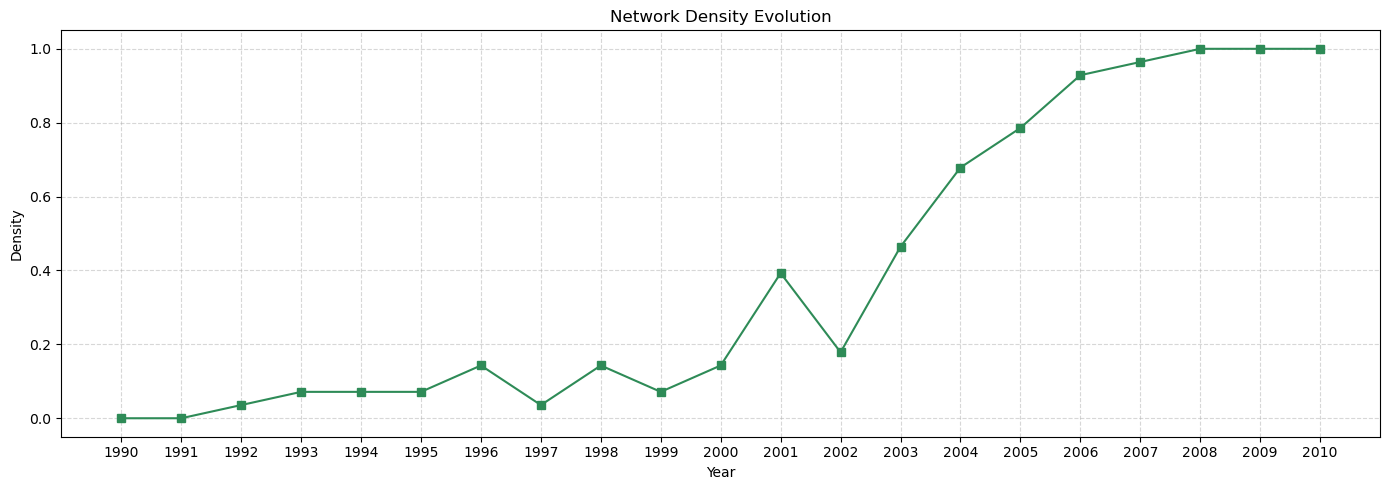

In [30]:
#plot the network density throughout the years

plt.figure(figsize=(14,5))
plt.plot(results_df['year'], results_df['density'], marker='s', linestyle='-', color='seagreen')
plt.xlabel('Year')
plt.ylabel('Density')
plt.title('Network Density Evolution')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(results_df['year'], [str(int(y)) for y in results_df['year']])
plt.tight_layout()
plt.savefig('../presentation/density_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

The diameter being low in early years is a bit misleading since there are not many edges in the network so its not fully connected

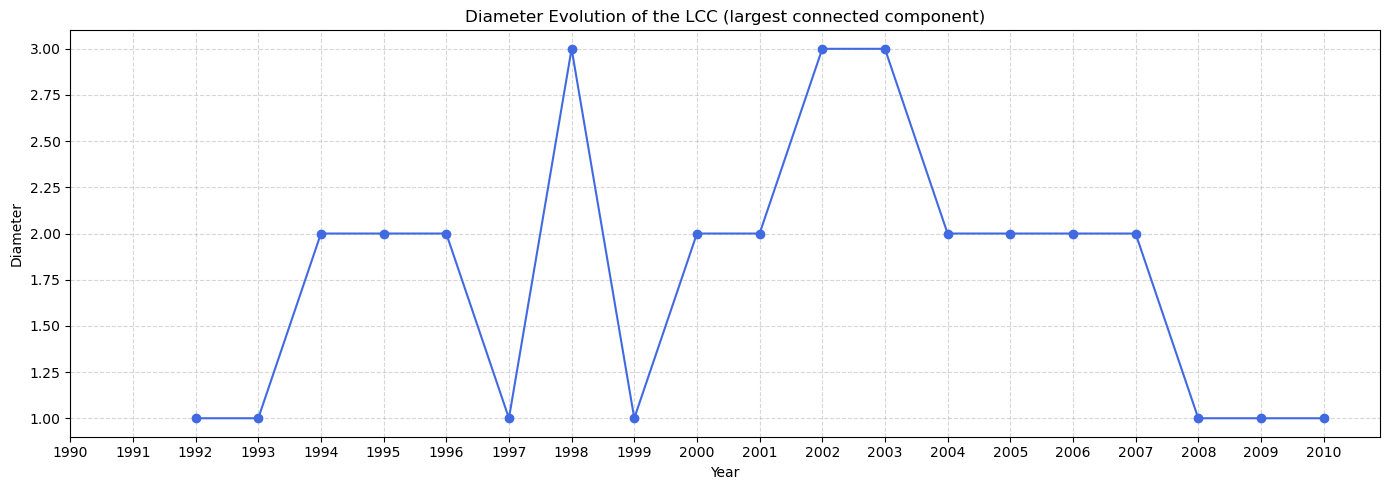

In [31]:
#plotting diameter evolution
plt.figure(figsize=(14,5))  
plt.plot(results_df['year'], results_df['diameter'], marker='o', linestyle='-', color='royalblue')
plt.xlabel('Year')
plt.ylabel('Diameter')
plt.title('Diameter Evolution of the LCC (largest connected component)')
plt.grid(True, linestyle='--', alpha=0.5)

plt.xticks(results_df['year'], [str(int(y)) for y in results_df['year']])
plt.tight_layout()

plt.savefig('../presentation/diameter_evolution.png', dpi=300, bbox_inches='tight')

plt.show()

#### Computing sum of edge weights for each family per year 
This is interpreted as number of conflicts or clashes with other families that year

In [32]:
# Stack all matrices into a 3D array (years × families × families)
years_sorted = sorted(matrices.keys())
matrices_3d = np.stack([matrices[year] for year in years_sorted], axis=0)  # Shape: (20, 10, 10)

# Sum across columns (axis=2) to get weight sum per family per year
# Result shape: (20, 10) - 20 years, 10 families
weight_sums = matrices_3d.sum(axis=2) #sum columns but keep the matrices and rows

# Create DataFrame
family_weights_df = pd.DataFrame(
    weight_sums,
    index=years_sorted,
    columns=family_cols
)

family_weights_df.index.name = 'year'
family_weights_df

,Beltran_Leyva,Familia,Golfo,Juarez,Sinaloa,Tijuana,Zetas,Otros
year,,,,,,,,
1990,0,0,0,0,0,0,0,0
1991,0,0,0,0,0,0,0,0
1992,0,0,0,0,0,1,1,0
1993,0,0,0,1,1,1,1,0
1994,0,0,1,0,0,2,1,0
1995,0,0,0,1,3,2,0,0
1996,0,0,2,2,4,2,0,0
1997,0,0,0,0,3,3,0,0
1998,0,0,3,1,4,3,1,0


#### Getting average weight per year 
To observe how that contrasts with number of conflicts/violence level per year

In [33]:
#average sum of edge weights per family for each year
avg_weights_df =  family_weights_df.mean(axis=1).to_frame(name='average_weight_sum')
avg_weights_df

,average_weight_sum
year,
1990,0.00
1991,0.00
1992,0.25
1993,0.50
1994,0.50
1995,0.75
1996,1.25
1997,0.75
1998,1.50


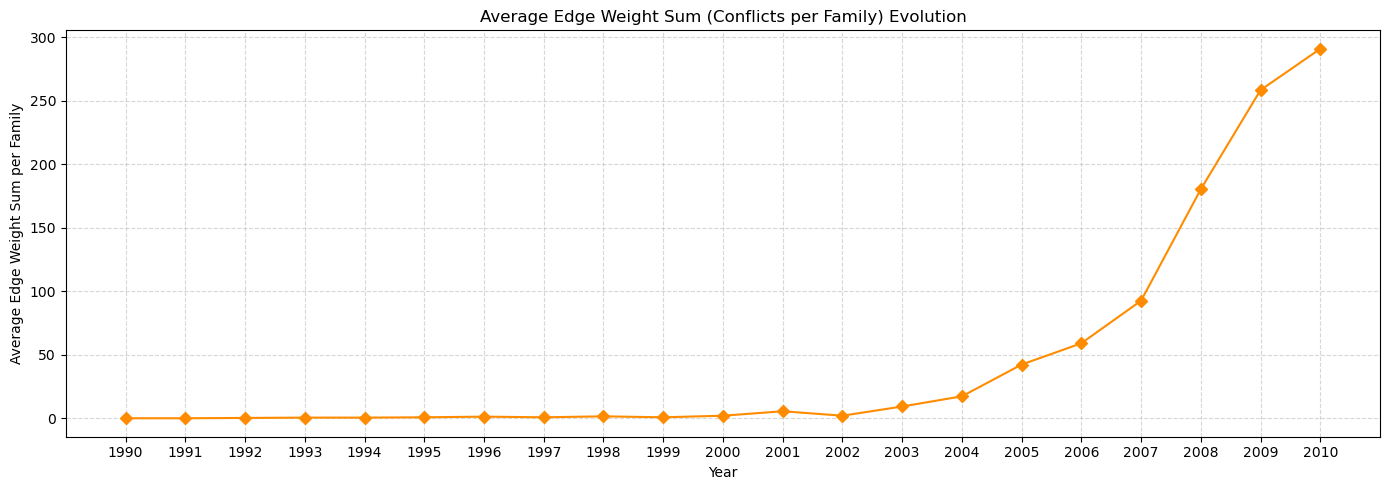

In [34]:
#plot the average sum of edge weights per family for each year
plt.figure(figsize=(14,5))
plt.plot(avg_weights_df.index, avg_weights_df['average_weight_sum'], marker='D', linestyle='-', color='darkorange')
plt.xlabel('Year')
plt.ylabel('Average Edge Weight Sum per Family')
plt.title('Average Edge Weight Sum (Conflicts per Family) Evolution')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(avg_weights_df.index, [str(int(y)) for y in avg_weights_df.index])
plt.tight_layout()
plt.savefig('../presentation/average_edge_weight_sum.png', dpi=300, bbox_inches='tight')
plt.show()

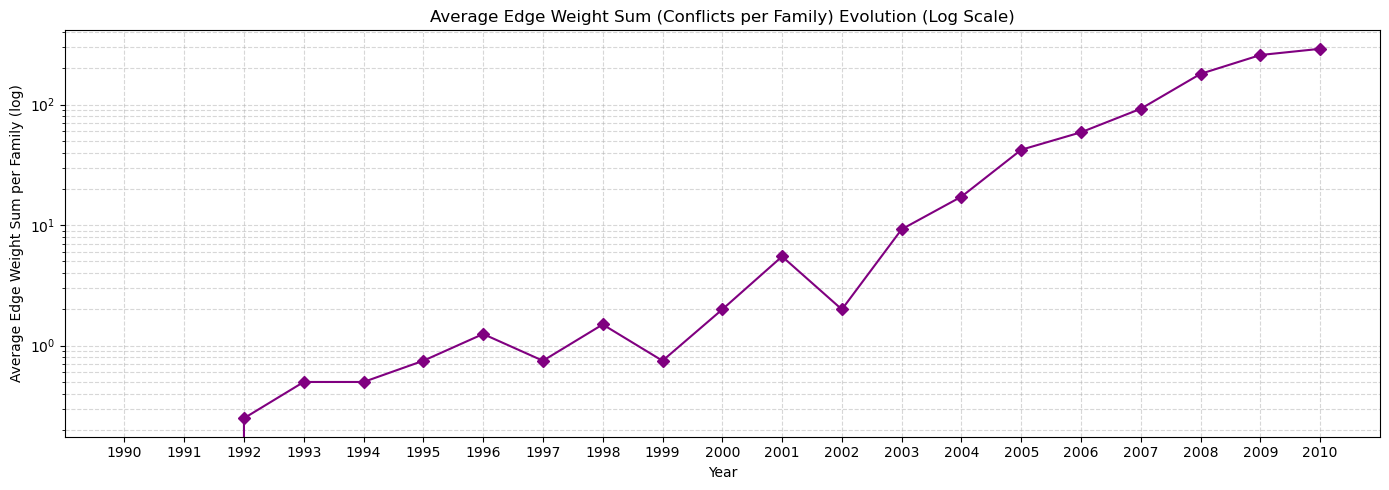

In [39]:
#plot the average sum of edge weights per family for each year (log scale)

plt.figure(figsize=(14,5))
plt.plot(avg_weights_df.index, avg_weights_df['average_weight_sum'], marker='D', linestyle='-', color='purple')
plt.xlabel('Year')
plt.ylabel('Average Edge Weight Sum per Family (log)')
plt.title('Average Edge Weight Sum (Conflicts per Family) Evolution (Log Scale)')
plt.yscale('log')
plt.grid(True, linestyle='--', alpha=0.5, which='both')
plt.xticks(avg_weights_df.index, [str(int(y)) for y in avg_weights_df.index])
plt.tight_layout()
plt.savefig('../presentation/average_edge_weight_sum_log.png', dpi=300, bbox_inches='tight')
plt.show()

#### Average Length of Shortest Path in Connected Component
A low avg length shows there are no local conflicts or alliances

In [40]:
avg_shortest_paths = []

for year in sorted(graphs_by_year.keys()):
    G = graphs_by_year[year]

    if nx.is_connected(G):
        avg_path = nx.average_shortest_path_length(G)
    else:
        components = list(nx.connected_components(G))

        if components:
            largest_cc = G.subgraph(max(components, key=len))

            if largest_cc.number_of_nodes() > 1:
                avg_path = nx.average_shortest_path_length(largest_cc)
            else:
                avg_path = float('nan')
        else:
            avg_path = float('nan')

    avg_shortest_paths.append({'year': year, 'avg_shortest_path': avg_path})
    
avg_shortest_paths_df = pd.DataFrame(avg_shortest_paths).set_index('year')
avg_shortest_paths_df

,avg_shortest_path
year,
1990,NaN
1991,NaN
1992,1.000000
1993,1.000000
1994,1.333333
1995,1.333333
1996,1.333333
1997,1.000000
1998,1.800000


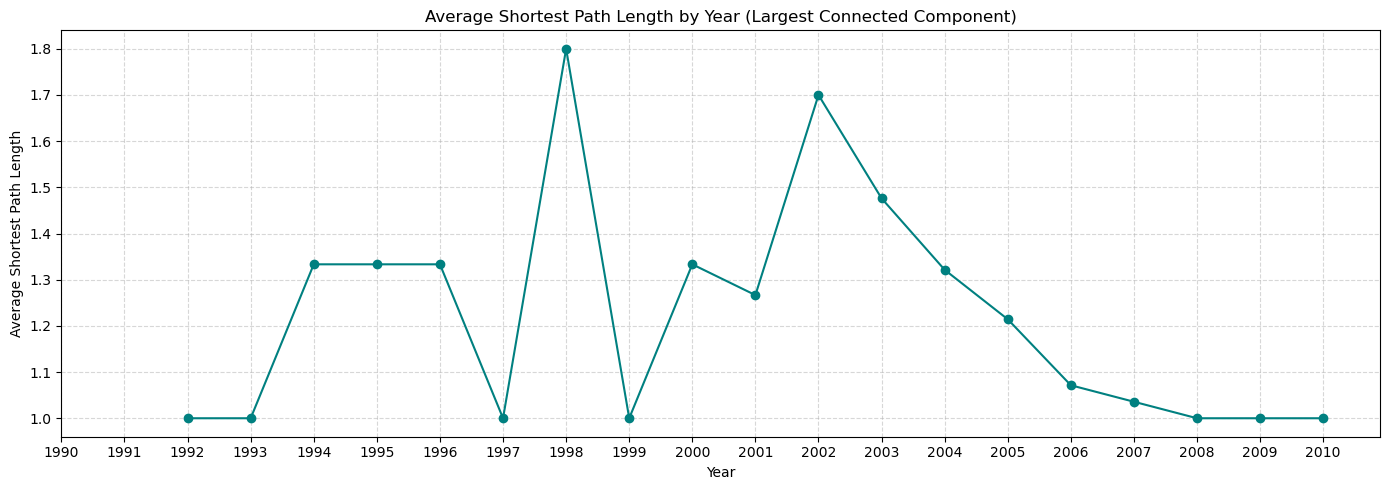

In [41]:
plt.figure(figsize=(14,5))
plt.plot(avg_shortest_paths_df.index, avg_shortest_paths_df['avg_shortest_path'], marker='o', linestyle='-', color='teal')
plt.xlabel('Year')
plt.ylabel('Average Shortest Path Length')
plt.title('Average Shortest Path Length by Year (Largest Connected Component)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(avg_shortest_paths_df.index, [str(int(y)) for y in avg_shortest_paths_df.index])
plt.tight_layout()
plt.savefig('../presentation/average_shortest_path_length.png', dpi=300, bbox_inches='tight')
plt.show()

---

### Assortativity Analysis

Testing whether powerful families (high municipal presence) preferentially co-occur with other powerful families

In [53]:
first_year = min(graphs_by_year.keys())
last_year = max(graphs_by_year.keys())

# Select years to visualize
years_to_plot = list(range(first_year, last_year + 1)) 

# defining layout once (so positions are consistent across years) - used 2010 network as reference as it's the most dense of them all 
pos = nx.spring_layout(graphs_by_year[2010], weight='weight', seed=42) 

frames = []
temp_dir = "network_frames_fixed_temp"
os.makedirs(temp_dir, exist_ok=True)

family_cols = df.columns[3:]

for idx, year in enumerate(years_to_plot):
    G = graphs_by_year[year]
    year_edges = G.edges()

    #node attribute: municipality presence
    df_year = df[df['Year'] == year][family_cols]
    munis_per_fam = df_year.sum(axis=0) 
    nx.set_node_attributes(G, munis_per_fam, 'municipal_presence')
    
    # Reindex to match G.nodes() order, then convert to list
    node_sizes = (500 + munis_per_fam.reindex(G.nodes()) * 20).tolist()

    # Reuse same node positions but adjust for missing nodes
    nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=node_sizes)
    nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")

    if len(year_edges) > 0:
        year_weights = np.array(list(G.edges(data='weight')))[:,2].astype(int)
        year_weights = year_weights / max_weight * 5  # normalize for plotting
        nx.draw_networkx_edges(G, pos, edgelist=year_edges, width=year_weights, edge_color="gray", alpha=0.6) 

    plt.title(f"Original Projected Network on Families - Year: {year}", fontsize=14)
    plt.axis('off')
    plt.tight_layout()

    # save year plots in a temporary directory
    fname = os.path.join(temp_dir, f"frame_{idx:02d}.png")
    plt.savefig(fname)
    plt.close()
    frames.append(imageio.imread(fname))

# turn all the images in the directory to a gif
imageio.mimsave('../PRESENTATION/network_evolution_muni_presence.gif', frames, fps=2)

# delete images from temporary directory
import shutil
shutil.rmtree(temp_dir)

print("Animation saved as 'network_evolution_muni_presence.gif'")

C:\Users\Maribel ITU\AppData\Local\Temp\ipykernel_22112\3567233158.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(fname))
C:\Users\Maribel ITU\AppData\Local\Temp\ipykernel_22112\3567233158.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(fname))
C:\Users\Maribel ITU\AppData\Local\Temp\ipykernel_22112\3567233158.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as 

Animation saved as 'network_evolution_muni_presence.gif'


It's a bit hard to tell from the animated plot, let's do a **scatter plot** of municipality presence

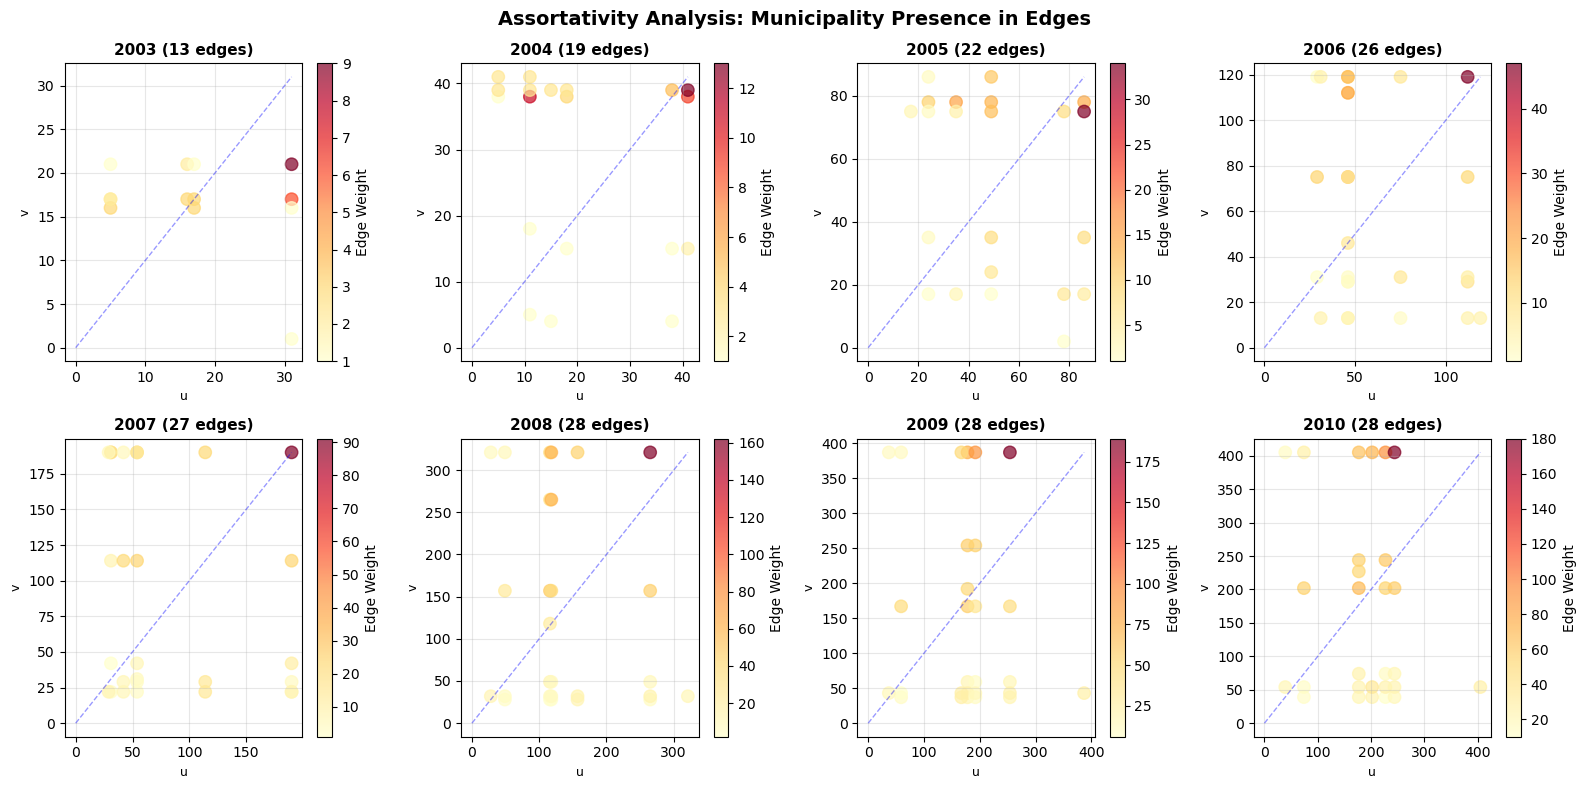

In [55]:
years_to_plot = list(range(2003, 2011))

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, year in enumerate(years_to_plot):
    ax = axes[i]
    G = graphs_by_year[year]
    
    
    # Extract edge data
    x_vals = []
    y_vals = []
    weights = []
    
    for u, v, w in G.edges(data='weight'):
        x_vals.append(G.nodes[u]['municipal_presence'])
        y_vals.append(G.nodes[v]['municipal_presence'])
        weights.append(w)
    
    # Plot with edge weight as color
    if x_vals:
        scatter = ax.scatter(x_vals, y_vals, c=weights, cmap='YlOrRd', 
                            alpha=0.7, s=80)
        
        # Diagonal line
        max_val = max(max(x_vals), max(y_vals))
        ax.plot([0, max_val], [0, max_val], 'b--', alpha=0.4, linewidth=1)
        
        # Colorbar
        plt.colorbar(scatter, ax=ax, label='Edge Weight')
    
    ax.set_xlabel('u', fontsize=9)
    ax.set_ylabel('v', fontsize=9)
    ax.set_title(f'{year} ({len(x_vals)} edges)', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.suptitle('Assortativity Analysis: Municipality Presence in Edges', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../presentation/assortativity_weighted_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

Also hard to find correlation, let's see if the backboned network gives more insightful results :)
